#Spam Detection using Naïve Bayes and Random Forest





##Naive Bayes

Naïve Bayes is a probabilistic classifier built on **Bayes’ Theorem:**


$$
P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$

It operates under the **assumption of feature independence**, meaning each feature (word) contributes independently to the classification. This makes the model computationally efficient and scalable.

In the context of **spam detection**, the classifier estimates the probability \( P(A|B) \), where:
- \( A \) represents the event that an email is **spam**.
- \( B \) represents the observed features (i.e., words in the email).

For example:

P(Spam | **"Congratulations! You have won a $1000 Walmart gift card. Click here to claim."**) --> Can we compute this probability?


The model learns these probabilities from training data and applies them to new emails to classify them as **spam** or **not spam**.
In other words, we just need to count how many the words included in the computation above, appears in spam/non-spam cases. Chances are that this count is higher for those cases belonging to spam than non-spam.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Step 1: Load Dataset
dataset_path = "/content/spam-classifier-dataset.csv"

data = pd.read_csv(dataset_path,encoding='latin-1')
data.head()

In [ ]:
data['label'] = data['label'].map({'no-spam': 0, 'spam': 1})
data.head()

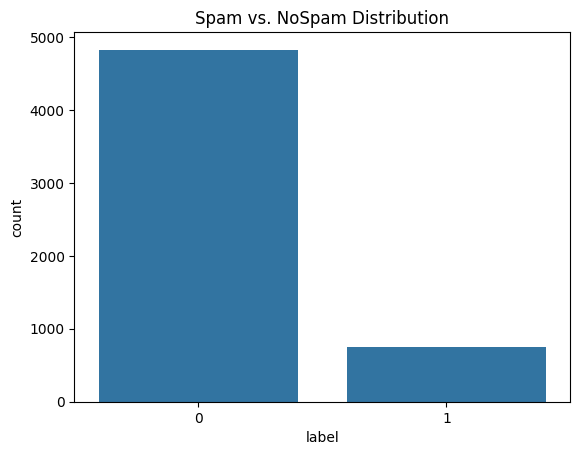

In [76]:
# Visualize class distribution
sns.countplot(x=data['label'])
plt.title('Spam vs. NoSpam Distribution')
plt.show()

##Dealing with un-even distributions: The class imbalance issue

####When working with imbalanced datasets, that is one class (e.g., spam) is notably less represented than the other (e.g., non-spam), your model may become biased toward the majority class, resulting in poor generalization.

#####How to address this issue?
######1. **Oversampling the minority class with SMOTE or random oversampling**.

- *SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic examples based on existing ones.*

- *Random Oversampling: Duplicates samples from the minority class to balance the dataset.*

```
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
```

######2. **Undersampling the Majority Class**
- *Random Undersampling: Removes random samples from the majority class*

```
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
```




In [77]:
# Step 2: Data Preprocessing
X = data['message']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



##Feature Engineering - TF-IDF Vectorization
Machine learning models cannot process raw text; we need to convert text into numerical representations.

### **TF-IDF (Term Frequency - Inverse Document Frequency)**
TF-IDF is a common technique used for transforming text into numerical values.

- **Term Frequency (TF):** Measures how frequently a word appears in a document.
- **Inverse Document Frequency (IDF):** Assigns higher importance to words that are unique in the dataset.

The IDF formula is given by:

$$
IDF = \log\left( \frac{\text{Total Number of Documents}}{\text{Number of Documents containing the word}} \right)
$$

This transformation ensures that common words (e.g., "the", "and", "is") receive lower importance, while rare but meaningful words contribute more to the classification.


In [78]:
#DOCUMENT A.K.A, EMAIL
print("****************************************************************************\n")
s1 = "Congratulations! You have won a $1000 Walmart gift card. Click here to claim."
print(s1)
print("****************************************************************************\n")
small_dataset = data.head(n=100)['message'].sample(n=100)
print(small_dataset)

****************************************************************************

Congratulations! You have won a $1000 Walmart gift card. Click here to claim.
****************************************************************************

45                     No calls..messages..missed calls
79    Its not the same here. Still looking for a job...
42    07732584351 - Rodger Burns - MSG = We tried to...
4     Nah I don't think he goes to usf, he lives aro...
97    i see. When we finish we have loads of loans t...
                            ...                        
76    Thats cool. i am a gentleman and will treat yo...
50    What you thinked about me. First time you saw ...
57                   Sorry, I'll call later in meeting.
25    Just forced myself to eat a slice. I'm really ...
48    Yeah hopefully, if tyler can't do it I could m...
Name: message, Length: 100, dtype: object


In [ ]:
# Initialize and apply TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english') # If a word occurs everywhere all the time, is not relevant!
X_train_tfidf = vectorizer.fit_transform(X_train)  # Learn vocabulary and transform training data

# A vocabulary refers to the set of unique words, also known as tokens extracted from the training dataset. Each word in this vocabulary becomes a feature used to transform text into a numerical representation.
print(vectorizer.vocabulary_)  # Dictionary of words and their assigned indices

"""
and 0
aax 1
...
...
...
...
zzz 40000
"""

#The larger the corpus i.e., the collection of documents you consider, the larger will be the memory needed to construct this matrix!
X_test_tfidf = vectorizer.transform(X_test)  # Transform test data using the same vocabulary

In [ ]:
# Step 3: Train Naïve Bayes Model
# The Multinomial Naïve Bayes classifier is suitable for text classification problems.
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)


#The Naïve Bayes (NB) model identifies patterns in the data by counting occurrences of elements.
#There are various other variations of ML models, such as Deep Learning models,  progressively more complex in their approach.

# Step 4: Evaluate Model
# Predictions and accuracy measurement
y_pred = nb_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
# The confusion matrix shows the number of correct and incorrect predictions.
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No-Spam', 'Spam'], yticklabels=['No-Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Step 6: Final evaluation
example_email = "Congratulations! You have won a $1000 Walmart gift card. Click here to claim."
email_tfidf = vectorizer.transform([example_email])
prediction = nb_classifier.predict(email_tfidf)[0]

# Example Usage
print(f'Example Email: {example_email}\nClassification: {prediction}')

# Decision Tree and Random Forest

A Decision Tree is a **supervised machine learning** algorithm used for both classification and regression tasks. It works by splitting the dataset into subsets based on the value of input features. The goal is to create a model that predicts the correct label by learning simple decision rules inferred from the data.

###Key Concepts:

 - Nodes: Represent decisions or tests on a feature.
 - Edges: Represent the outcome of a decision.
 - Leaf Nodes: Represent the final decision or prediction (e.g., spam or not spam).
 - Splitting: The process of dividing a node into sub-nodes based on a condition  (e.g., "Is the word 'free' in the email?").
 - Impurity Measures: Metrics like Gini impurity or entropy are used to decide  the best split.

###Example:

*Does the email contain the word "free"?*

*Does the email contain the word "money"?*

```
Is "free" in the email?
  ├── Yes: Is "money" in the email?
  │      ├── Yes: Spam
  │      └── No: Not Spam
  └── No: Not Spam
```

We can potentially engineer an arbitrary number of features!
Yes but.....chances are that we need to restart our laptop :-)

##What is a Random Forest?
Random Forest is an ensemble learning method that builds multiple decision trees.
*Key advantages:*
- Reduces Overfitting: By averaging multiple trees, it generalizes better.
- Handles High Dimensionality: Effective for text classification tasks like spam detection.

###High Dimensionality??

1. **Each decision tree in the forest considers a random subset of features** to ensure diversity among trees and reduce reliance on any single feature.  

2. **Prevents overfitting** by ensuring the model doesn’t depend too heavily on specific features, improving generalization to new data.  

3. **Trees are trained independently**, allowing efficient parallel processing to handle large datasets and high-dimensional feature spaces.

### **How a Random Forest is Trained (Simple Explanation)**

1. **Gather Data**:  
   Collect a dataset with features (e.g., #of_certain_words) and labels (e.g., "yes" or "no" for a decision).

2. **Build Multiple Decision Trees**:  
   Instead of creating just one decision tree, a random forest builds many trees. Each tree acts as an independent decision-maker.

3. **Random Sampling (Bootstrapping)**:  
   For each tree, randomly select a subset of the data. Some data points may be picked multiple times, while others may not be picked at all. This ensures each tree sees slightly different data.

4. **Random Feature Selection**:  
   At each step (node) in building a tree, only a random subset of features is considered for splitting the data. This adds diversity to the trees.

5. **Grow the Trees**:  
   Each tree is grown by asking yes/no questions about the features to split the data into smaller groups. This process continues until the tree reaches a stopping point (e.g., a maximum depth).

6. **Combine Predictions**:  
   Once all trees are built, they "vote" on the final prediction. For example, in classification, the majority vote determines the outcome. In regression, the average of all tree predictions is taken.

7. **Final Model**:  
   The random forest is the combination of all these trees. By leveraging many trees and introducing randomness, the model becomes more accurate and robust compared to a single decision tree.
   

In [ ]:
  # Step 1 and Step 2 -- Nothing has changed [Re-execute for consistency]

# Step 3: Random Classifier
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_transformed = vectorizer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


###Hyperparameters selection.
  
  - **max_features**: Controls the number of features considered at each split in a tree, introducing randomness and reducing overfitting.

  - **n_estimators**: Determines the total number of trees in the forest, with more trees, performance generally improves.

Hyperparameters are adjustable settings that control how a model learns and performs, impacting accuracy, efficiency, and generalization. Selecting the right ones is crucial but time-consuming, especially for complex models like Large Language Models (LLMs), which require extensive tuning and large-scale computations. Methods like Grid Search, Random Search, or Bayesian Optimization help streamline this process, balancing performance and efficiency.

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



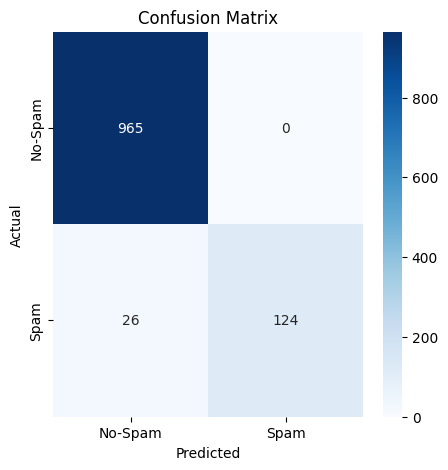

Example Email: Congratulations! You have won a $1000 Walmart gift card. Click here to claim.
Classification: 1


In [71]:
# Step 4: Evaluate Model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
# The confusion matrix shows the number of correct and incorrect predictions.
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No-Spam', 'Spam'], yticklabels=['No-Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Step 6: Final evaluation
example_email = "Congratulations! You have won a $1000 Walmart gift card. Click here to claim."
email_tfidf = vectorizer.transform([example_email])
prediction = rf_classifier.predict(email_tfidf)[0]

# Example Usage
print(f'Example Email: {example_email}\nClassification: {prediction}')
